# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import importlib
from pathlib import Path
import scipy.signal as signal
 
# from DSPFuncs import DCRemover
import Adaptive
import CantileverBeam
importlib.reload(CantileverBeam)
importlib.reload(Adaptive)

from DSPFuncs import DCRemover


# Cantilever Beam Frequencies and Modes

Natural frequencies are: [  6.24198915  39.11343994 109.50756621 214.56860725].


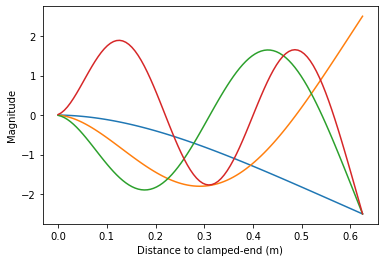

In [3]:
# A beam instance with length of 62.5 cm, width of 4.3 cm and thicknes of 3 mm:
beam = CantileverBeam.CantileverBeam(npoints=100,length=62.5e-2,width=4.3e-2,thickness=3e-3,nmodes=4)

# Natural frequencies in beam.freqHz
print(f"Natural frequencies are: {beam.freqsHz}.")

# Mode shape plots
x,modes = beam.getModeShapes()
# plotting one shape for each mode:
fig,ax = plt.subplots(1,1)
for n in range(beam.nmodes):
    ax.plot(x,modes[:,n])
ax.set_xlabel("Distance to clamped-end (m)")
ax.set_ylabel("Magnitude")

plt.show()

# Adaptive System Identification

In [4]:
data = pd.read_parquet((Path() / "SampleSignals"  / "Measurements1.parquet"))
display(data.head(5))

,Tempo (s),DAC 1,DAC 2,DAC 3,DAC 4,IMU1AccX,IMU1AccY,IMU1AccZ,IMU1GyroX,IMU1GyroY,IMU1GyroZ,IMU2AccX,IMU2AccY,IMU2AccZ,IMU2GyroX,IMU2GyroY,IMU2GyroZ
0,0.000,-0.435851,-1.0,-1.0,-1.0,0.187945,9.740809,0.486023,4.333496,-3.326416,-3.601074,0.169988,9.731233,0.676362,2.044678,-6.866455,-2.426147
1,0.004,-0.528777,-1.0,-1.0,-1.0,0.187945,9.740809,0.486023,4.333496,-3.326416,-3.601074,0.159214,9.715670,0.604536,2.136230,-6.835938,-2.410889
2,0.008,0.193046,-1.0,-1.0,-1.0,0.180762,9.740809,0.579397,4.119873,-3.372192,-3.631592,0.159214,9.715670,0.604536,2.136230,-6.835938,-2.410889
3,0.012,0.143285,-1.0,-1.0,-1.0,0.180762,9.740809,0.579397,4.119873,-3.372192,-3.631592,0.159214,9.715670,0.604536,2.136230,-6.835938,-2.410889
4,0.016,-0.440647,-1.0,-1.0,-1.0,0.180762,9.740809,0.579397,4.119873,-3.372192,-3.631592,0.186748,9.805453,1.221043,2.578735,-6.866455,-2.502441


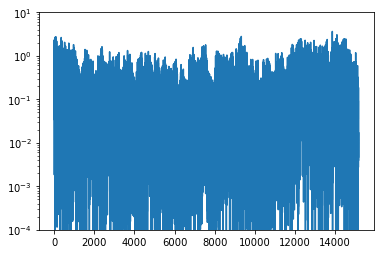

In [7]:

indata = data["DAC 1"].values  # Input signal: does not need to remove DC level since this signal is already zero mean
outdata = DCRemover().filter(data["IMU2AccZ"].values)  # Remove DC level from output signal, making convergence faster. 

# Create instance of FIR-NLMS adaptive filter, which will be used for modeling the desired path/system:
firnlms = Adaptive.FIRNLMS(memorysize=2500,stepsize=0.5,regularization=1e-3)  # memorysize = number of filter coeficients, stepsize = must be smaller than one, regularization = noise variance is a good choice.


# Run the system modeling using the FIR-NLMS filter:
firnlms.run(indata, outdata, maxiter=None)

# Plot the squared error observed during the modeling.
plt.semilogy(firnlms.sqerror)
plt.ylim(1e-4,1e1)
plt.show()


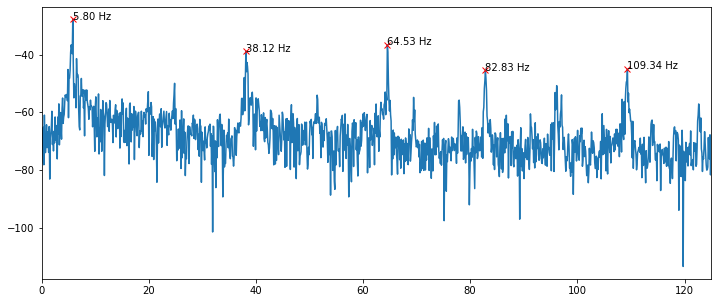

In [9]:
# Now, by taking the fft of the obtained coefficient vector (obtained impulse response), 
# we can observe the frequency response of the system:
# Coefficient vector is given by firnlms.ww. 

magfftdb = 20*np.log10(1/250*np.abs(np.fft.fft(firnlms.ww)))
freqs = np.linspace(0, 250, magfftdb.shape[0])

fig,ax = plt.subplots(1,1)
ax.plot(freqs,magfftdb)

peaks,props = signal.find_peaks(magfftdb,distance=50,height=-48)
npeaks = 5 # Até 5 picos serão considerados
peakfreqs = freqs[peaks[0:npeaks]]  # Os npeaks primeiros
peakvals = props['peak_heights'][0:npeaks]  # Os npeaks primeiros
ax.plot(peakfreqs,peakvals,"xr")
for k in range(min([npeaks,peakfreqs.shape[0]])):
  if peakfreqs[k] <= 125: # somente plota até 125 Hz
    ax.text(peakfreqs[k],peakvals[k],f"{peakfreqs[k]:.2f} Hz")

ax.set_xlim(0,125)
fig.set_size_inches(12,5)

plt.show()